# Bike Sharing - Linear Regression Assignment

## Problem Statement

The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

In [1]:
# Importing all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#library for train_test_split
import sklearn
from sklearn.model_selection import train_test_split
#library for minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# for modelling
import statsmodels.api as sm  
# for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

## Step 1: Reading and Understanding the Data

In [3]:
#load the file to the dataset
bike_share = pd.read_csv('day.csv')
bike_share.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#remove unwanted columns
bike_share.drop(columns=['instant','dteday','casual','registered'],inplace=True)

In [5]:
bike_share.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


In [6]:
bike_share.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


No Null values present!!!

## Step 2: Visualising the Data

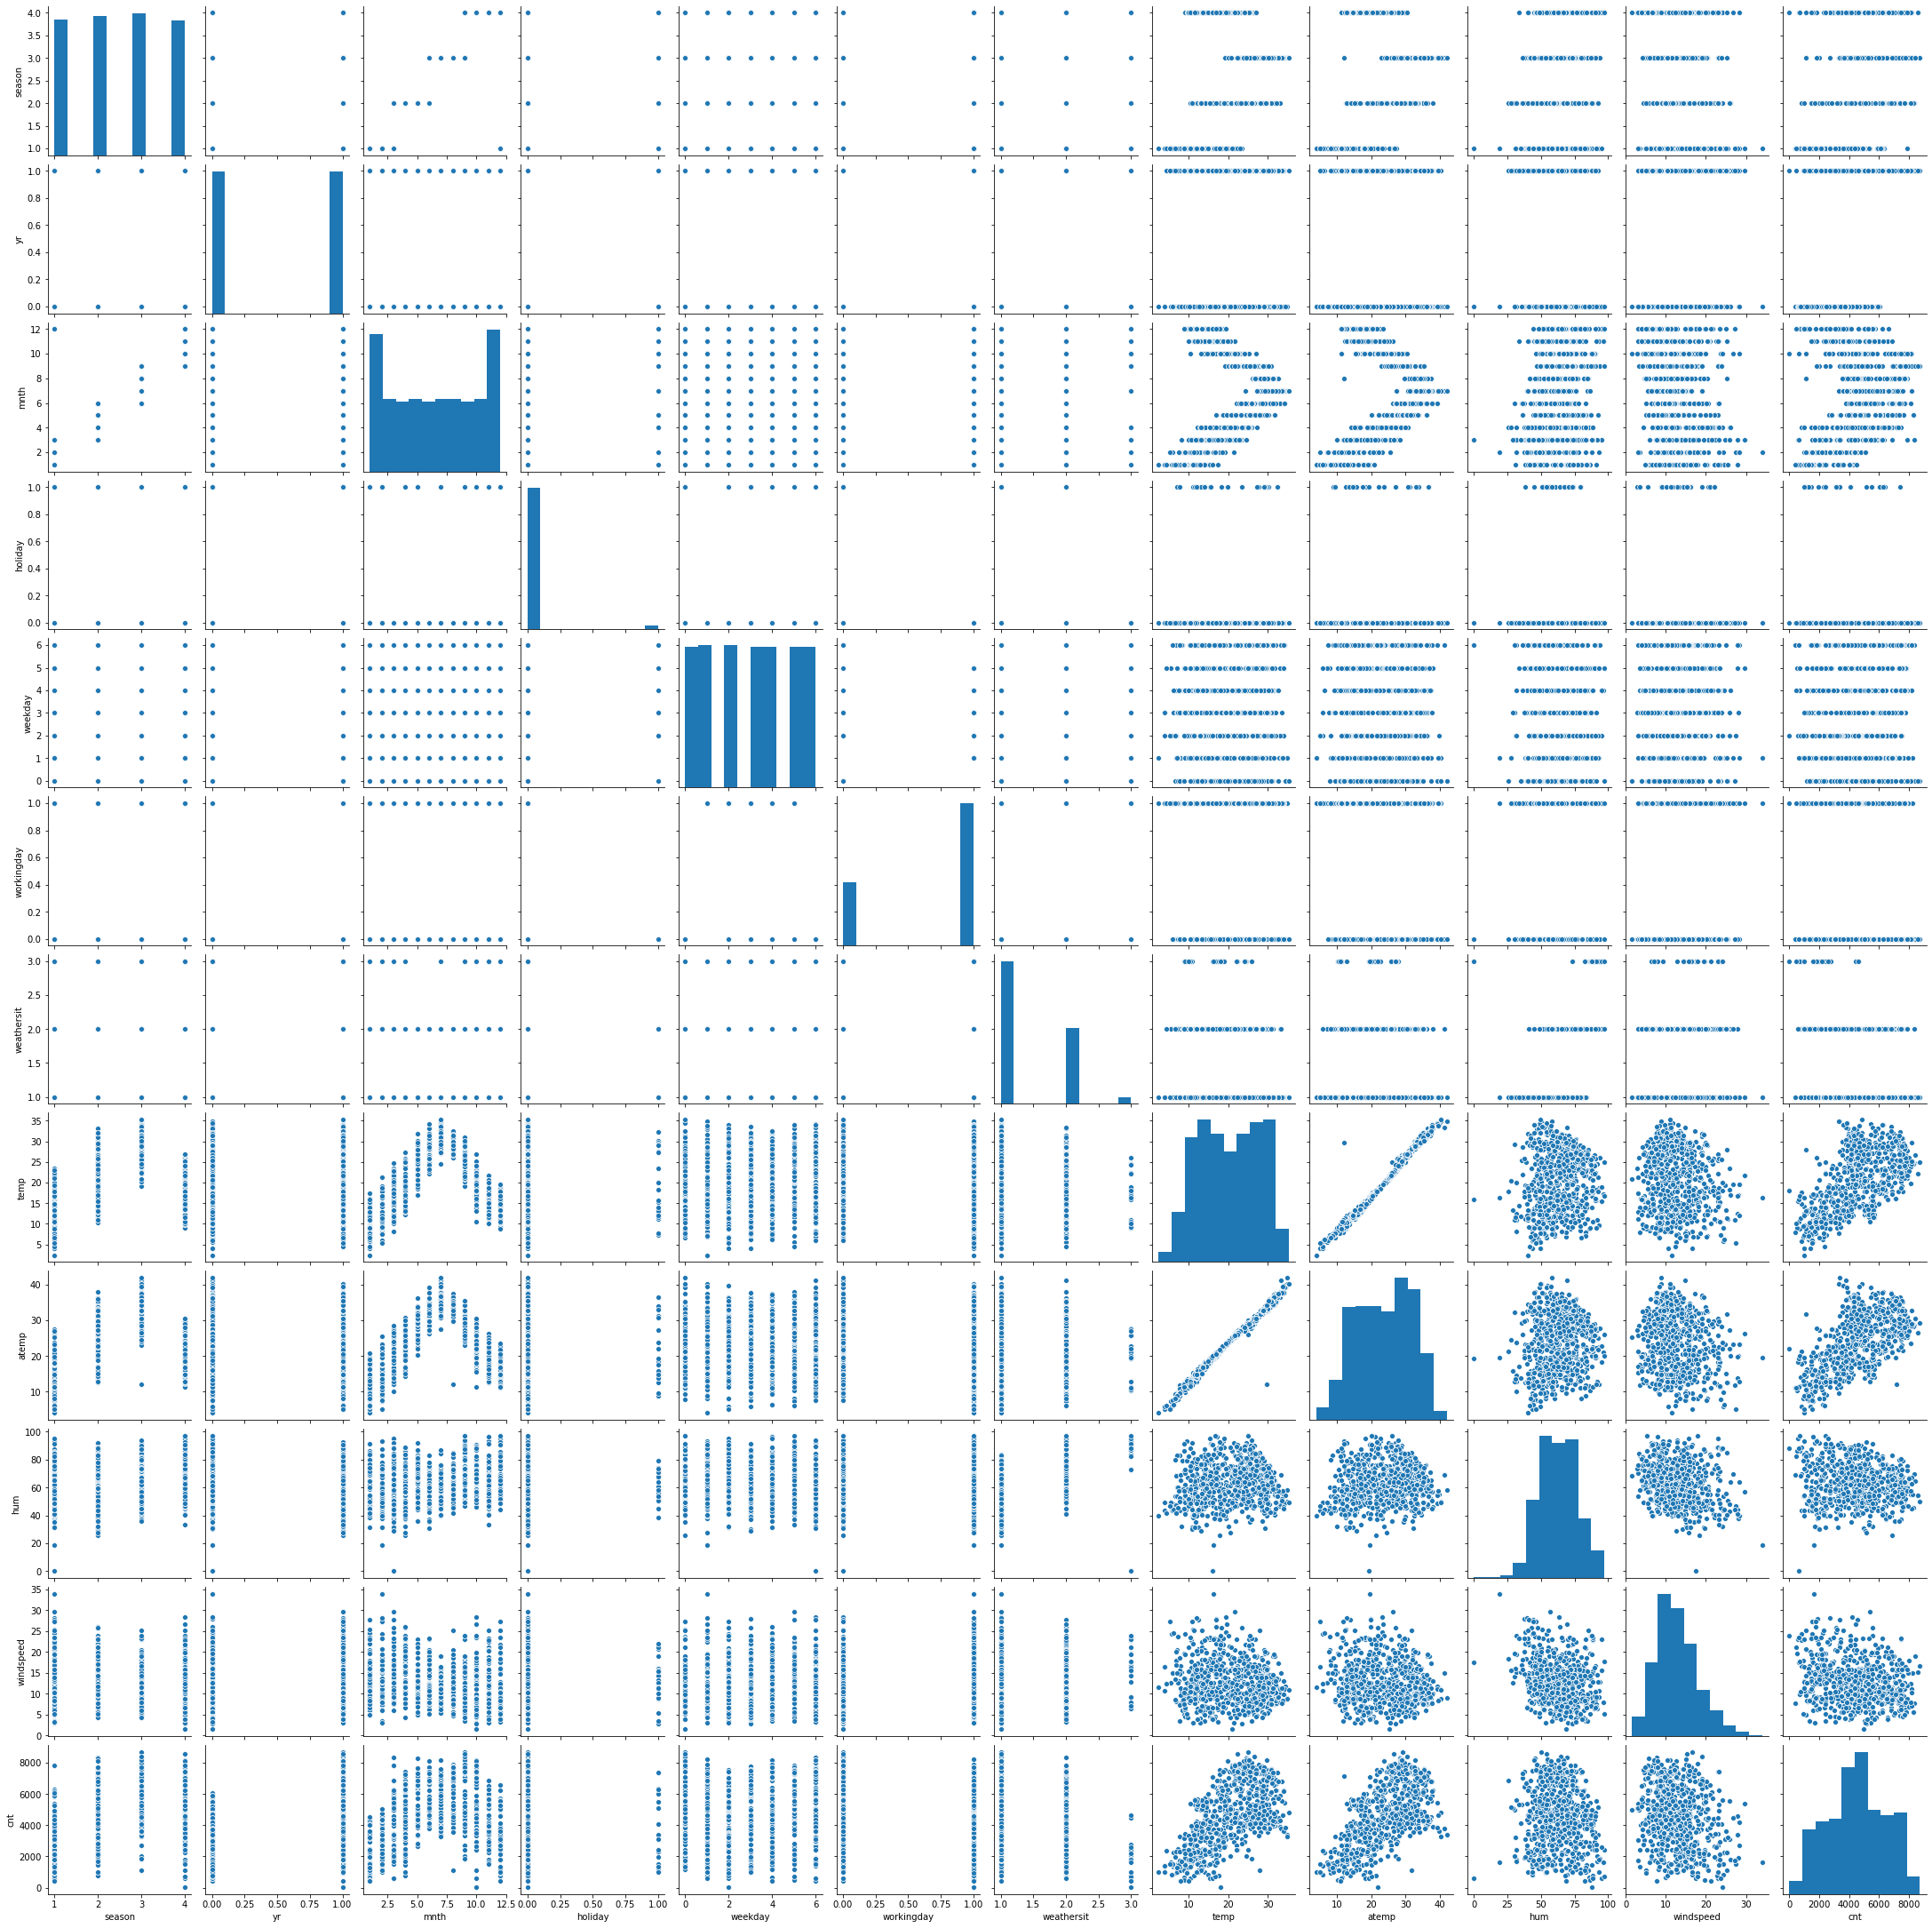

In [7]:
sns.pairplot(bike_share)
plt.show()

#### Inferences

- atemp and temp shows high correlations which may result in multicollinearity.(one variable removed through RFE)
- temp looks like a significant variable to be considered for regression analysis of cnt as the graph looks likely to linear relationship
- In yr, 2019 has higher counts compariteively
- With respect to month, season, the mid period of year has the good demand for bike share.

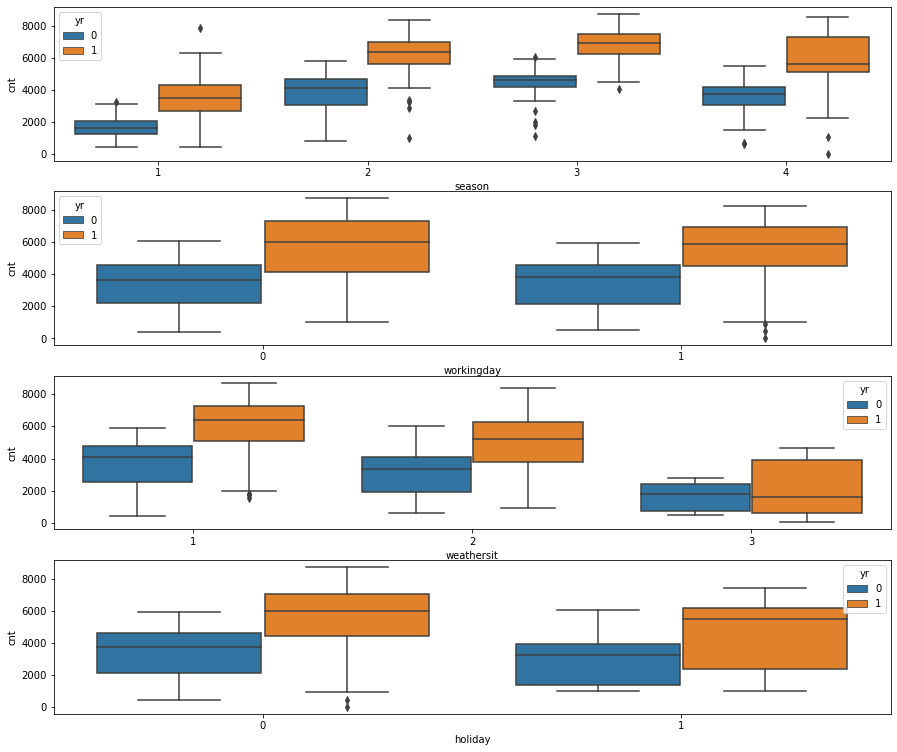

In [8]:
#Plot season, workingday, weathersit and holiday vs yr vs cnt
plt.figure(figsize = (15, 13))
plt.subplot(4,1,1)
sns.boxplot(x = 'season', y = 'cnt', hue = 'yr', data = bike_share)
plt.subplot(4,1,2)
sns.boxplot(x = 'workingday', y = 'cnt', hue = 'yr', data = bike_share)
plt.subplot(4,1,3)
sns.boxplot(x = 'weathersit', y = 'cnt', hue = 'yr', data = bike_share)
plt.subplot(4,1,4)
sns.boxplot(x = 'holiday', y = 'cnt', hue = 'yr', data = bike_share)
plt.show()

From the above plots, we infer that
- The demand of bike sharing have risen in 2019.
- From the season plot, we see that Spring(1) has very less demand compared to other seasons in a year
- On holidays, the demand is bit decreased as office commute will be less.
- People prefer bike share only when the skies are clear or misty.

## Step 3: Data Preparation

### Dummy variables 

- Categorical Variables: Season, Month, weekday, weathersit 
- yr column has been renamed to yr 2019

In [5]:
# Label transformation and renaming of yr column
bike_share['season'].replace({1:'Spring',2:'Summer',3:'Autumn',4:'Winter'},inplace= True)
bike_share['mnth'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace= True)
bike_share['weekday'].replace({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',0:'Sun'},inplace= True)
bike_share['weathersit'].replace({1:'Clear',2:'Misty',3:'Light Rain/Snow',4:'Heavy Rain/Snow'},inplace= True)
bike_share.rename(columns = {'yr':'yr 2019'}, inplace = True)
bike_share.head()

,season,yr 2019,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Mon,1,Misty,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,Jan,0,Tue,1,Misty,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [6]:
#create dummy variables
season= pd.get_dummies(bike_share['season'], drop_first=True)
month = pd.get_dummies(bike_share['mnth'], drop_first=True)
weekday = pd.get_dummies(bike_share['weekday'], drop_first=True)
weathersit = pd.get_dummies(bike_share['weathersit'], drop_first=True)
pd.set_option('display.max_columns', 50)
final = pd.concat([bike_share , season, month, weekday, weathersit], axis=1)

In [7]:
#remove unwanted columns
final.drop(columns=['season','mnth','weekday','weathersit'],inplace=True)
final.head()

,yr 2019,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain/Snow,Misty
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 4: Splitting the Data into Training and Testing Sets

In [8]:
f_train,f_test = train_test_split(final, train_size=0.7, random_state=100)
print(f_train.shape)
print(f_test.shape)

(510, 30)
(220, 30)


In [9]:
#initalize an object
scaler= MinMaxScaler()
#variables to be scaled
nvar = ['temp','atemp','hum','windspeed','cnt']
#fit and transform the data using scaler
f_train[nvar]=scaler.fit_transform(f_train[nvar])

In [10]:
f_train.head()

,yr 2019,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain/Snow,Misty
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
728,1,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
111,0,0,0,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


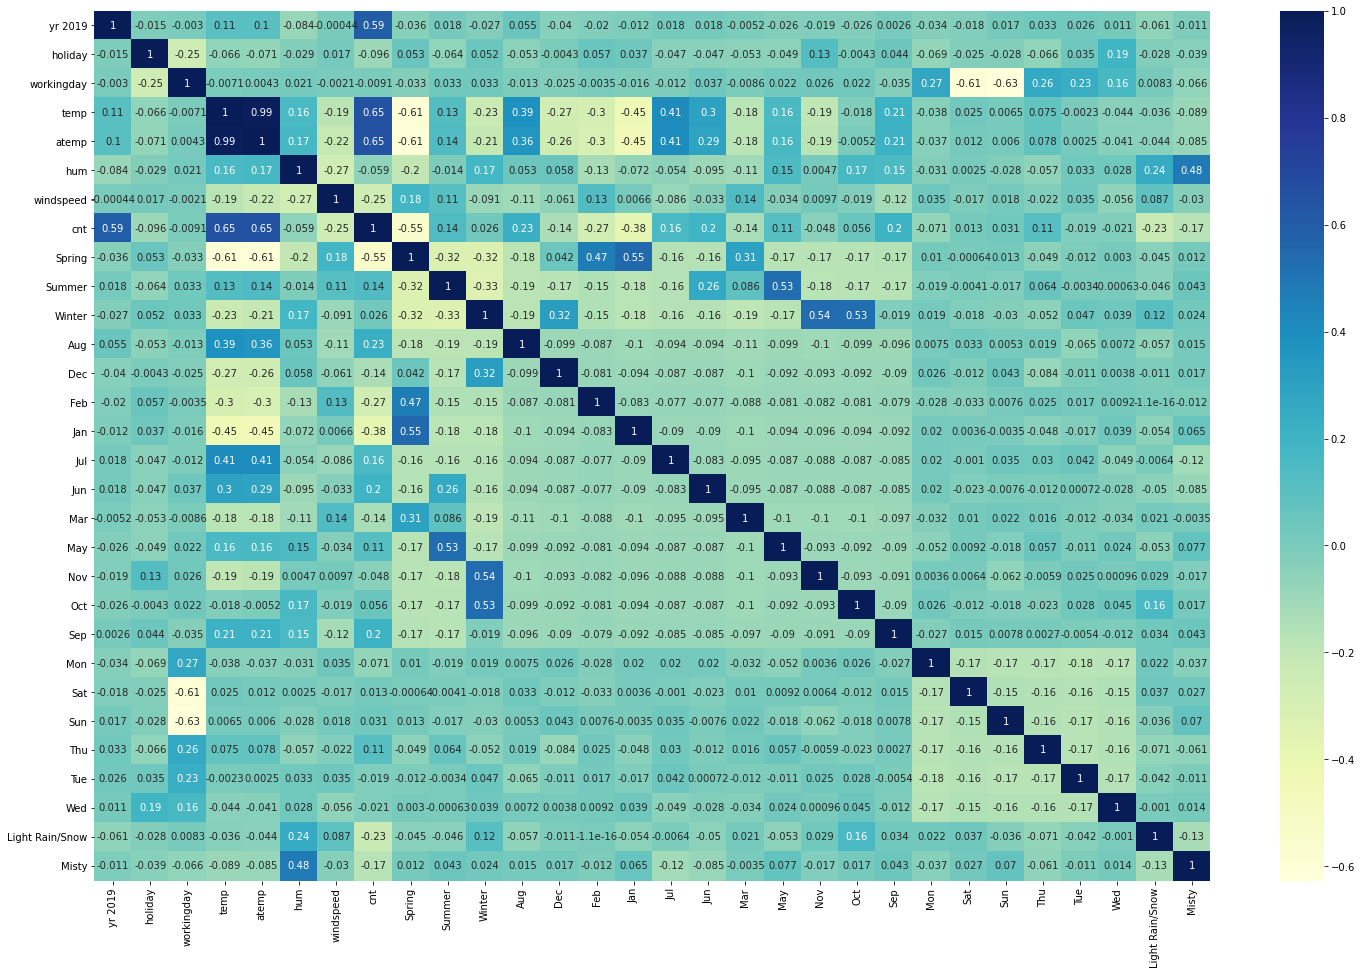

In [58]:
#correlation plot of all variables in train
plt.figure(figsize = (25, 16))
sns.heatmap(f_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

We see that the temp and atemp is highy corelated to count. Hence will plot the scatter for the corresponding variable.

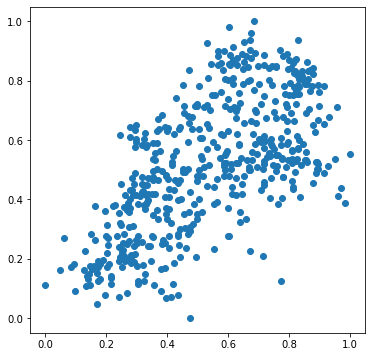

In [59]:
#plot of variable temp with cnt which has high correlation
plt.figure(figsize=[6,6])
plt.scatter(f_train.temp, f_train.cnt)
plt.show()

In [11]:
#divide into X and y sets
y_train = f_train.pop('cnt')
X_train = f_train

## Step 5: Building a linear model

In [12]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [13]:
#variables selected by RFE
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr 2019', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('atemp', False, 3),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Aug', False, 10),
 ('Dec', True, 1),
 ('Feb', False, 2),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 12),
 ('Mar', False, 15),
 ('May', False, 9),
 ('Nov', True, 1),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Mon', False, 8),
 ('Sat', False, 5),
 ('Sun', False, 6),
 ('Thu', False, 14),
 ('Tue', False, 7),
 ('Wed', False, 11),
 ('Light Rain/Snow', True, 1),
 ('Misty', True, 1)]

In [14]:
# add the 15 columns selected by RFE to the variable col
col = X_train.columns[rfe.support_]
col

Index(['yr 2019', 'holiday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer',
       'Winter', 'Dec', 'Jan', 'Jul', 'Nov', 'Sep', 'Light Rain/Snow',
       'Misty'],
      dtype='object')

In [15]:
# Creating X_test dataframe with RFE selected  15 variables
X_train_rfe = X_train[col]

In [16]:
# adding constant for the intercept
X_train_rfe = sm.add_constant(X_train_rfe)

In [17]:
# run the model
lm = sm.OLS(y_train,X_train_rfe).fit() 
#summary of the model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          8.15e-189
Time:                        19:35:44   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3197      0.036     

In [18]:
vif = pd.DataFrame()
X = X_train_rfe.drop(['const'], axis=1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,30.89
2,temp,17.79
4,windspeed,4.72
5,Spring,4.37
7,Winter,4.06
6,Summer,2.82
14,Misty,2.32
0,yr 2019,2.09
11,Nov,1.85
9,Jan,1.75


In [19]:
# As we have to reduce the variables to 10, removing hum which has VIF > 5
X = X.drop(['hum'], axis=1)
# Add constant
Xtrain_sm = sm.add_constant(X)
# recreate the codel and fit
lm = sm.OLS(y_train,Xtrain_sm).fit() 
#summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     184.5
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          4.75e-186
Time:                        19:36:40   Log-Likelihood:                 504.85
No. Observations:                 510   AIC:                            -979.7
Df Residuals:                     495   BIC:                            -916.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2450      0.032     

In [20]:
vif = pd.DataFrame()
X = Xtrain_sm.drop(['const'], axis=1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,5.17
3,windspeed,4.67
6,Winter,2.95
4,Spring,2.89
5,Summer,2.24
0,yr 2019,2.07
10,Nov,1.81
8,Jan,1.66
9,Jul,1.59
13,Misty,1.57


In [21]:
# As we have to reduce the variables to 10, removing Nov which has VIF > 5
X = X.drop(['temp'], axis=1)
# Add constant
Xtrain_sm = sm.add_constant(X)
# recreate the codel and fit
lm = sm.OLS(y_train,Xtrain_sm).fit() 
#summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     144.9
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          1.82e-159
Time:                        19:45:24   Log-Likelihood:                 438.84
No. Observations:                 510   AIC:                            -849.7
Df Residuals:                     496   BIC:                            -790.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5954      0.016     

In [22]:
# As we have to reduce the variables to 10, removing jan which has high p value
X = X.drop(['Jul'], axis=1)
# Add constant
Xtrain_sm = sm.add_constant(X)
# recreate the codel and fit
lm = sm.OLS(y_train,Xtrain_sm).fit() 
#summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     157.0
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          2.08e-160
Time:                        19:47:42   Log-Likelihood:                 438.45
No. Observations:                 510   AIC:                            -850.9
Df Residuals:                     497   BIC:                            -795.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5886      0.014     

In [23]:
# As we have to reduce the variables to 10, removing jan which has high p value
X = X.drop(['Winter'], axis=1)
# Add constant
Xtrain_sm = sm.add_constant(X)
# recreate the codel and fit
lm = sm.OLS(y_train,Xtrain_sm).fit() 
#summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     171.2
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          2.71e-161
Time:                        19:50:02   Log-Likelihood:                 437.88
No. Observations:                 510   AIC:                            -851.8
Df Residuals:                     498   BIC:                            -800.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5834      0.013     

In [24]:
vif = pd.DataFrame()
X = Xtrain_sm.drop(['const'], axis=1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.23
3,Spring,2.37
0,yr 2019,1.74
4,Summer,1.70
6,Jan,1.62
10,Misty,1.48
7,Nov,1.23
8,Sep,1.16
5,Dec,1.13
9,Light Rain/Snow,1.07


#### FINAL MODEL

In [25]:
# As we have to reduce the variables to 10, removing jan which has VIF > 3 value
X = X.drop(['windspeed'], axis=1)
# Add constant
Xtrain_sm = sm.add_constant(X)
# recreate the codel and fit
lm = sm.OLS(y_train,Xtrain_sm).fit() 
#summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     169.0
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          3.79e-153
Time:                        19:57:18   Log-Likelihood:                 415.91
No. Observations:                 510   AIC:                            -809.8
Df Residuals:                     499   BIC:                            -763.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5309      0.011     

In [26]:
vif = pd.DataFrame()
X = Xtrain_sm.drop(['const'], axis=1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Spring,1.84
5,Jan,1.61
0,yr 2019,1.55
9,Misty,1.44
3,Summer,1.31
6,Nov,1.12
7,Sep,1.12
4,Dec,1.10
1,holiday,1.06
8,Light Rain/Snow,1.03


## Step 6: Residual Analysis of the train data

In [28]:
#predict values in train
y_train_pred = lm.predict(Xtrain_sm)

Text(0.5, 1.0, 'Residual Analysis of train dataset')

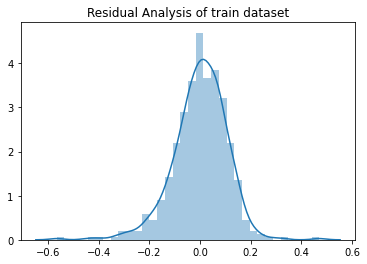

In [50]:
res = y_train - y_train_pred
sns.distplot(res)
plt.title('Residual Analysis of train dataset')

- We see the residual is distributed normally and with the mean of 0

## Step 7: Making Predictions Using the Final Model

In [30]:
#transform the test dataset on the trained scale
f_test[nvar]=scaler.transform(f_test[nvar])

In [31]:
f_test.describe()

,yr 2019,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light Rain/Snow,Misty
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,0.059091,0.086364,0.100000,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364,0.118182,0.172727,0.154545,0.140909,0.122727,0.159091,0.027273,0.318182
std,0.500809,0.187620,0.480828,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,0.236333,0.281541,0.300684,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541,0.323559,0.378873,0.362295,0.348721,0.328872,0.366595,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
#split X and Y
y_test = f_test.pop('cnt')
X_test = f_test

In [33]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test using columns used in the final model dataset
X_test_new = X_test[X.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [34]:
#predict the test data from the model trained
y_test_pred = lm.predict(X_test_new)

## Step 8: Model Evaluation

Text(0, 0.5, 'y_pred')

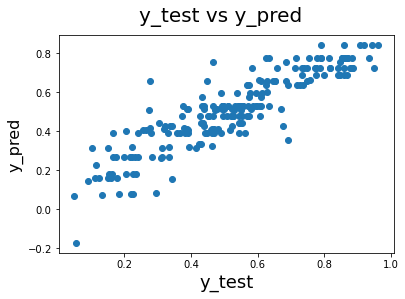

In [35]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

We see the plot of y_pred and y_test is almost linear with slight co-variance

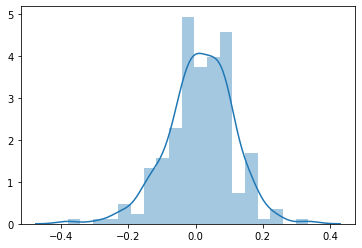

In [40]:
#predict values in train
y_test_pred = lm.predict(X_test_new)
#residual values
res = y_test - y_test_pred
sns.distplot(res)

from the above plot we see the distribution is normal in test dataset

In [37]:
# R2 score on the test dataset 
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.7917924239682566

### R- squared value on the test dataset is 79.18 %

Text(0, 0.5, 'Views')

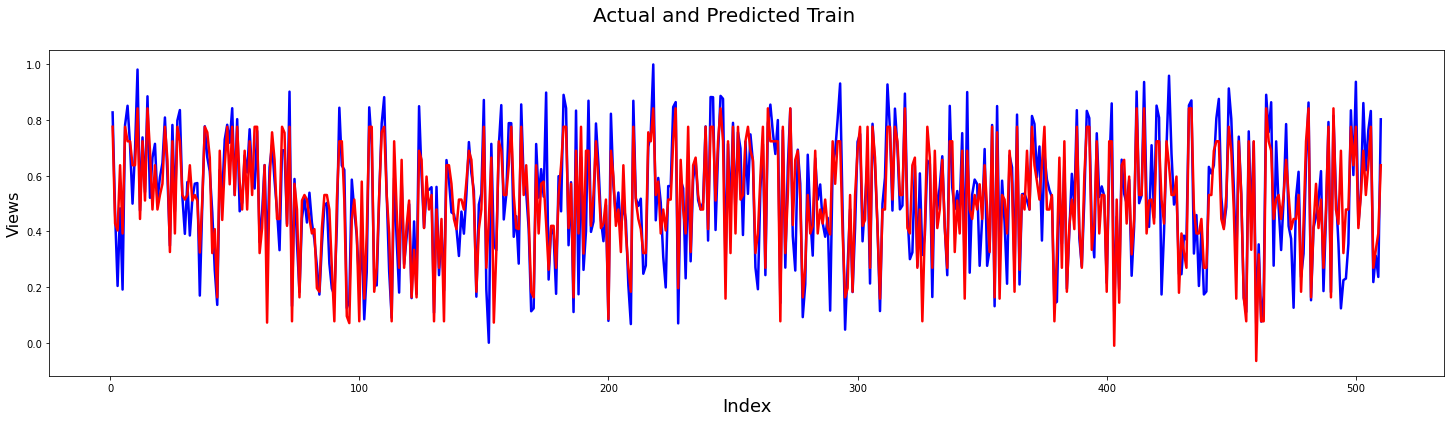

In [45]:
#Actual vs Predicted on train dataset
c = [i for i in range(1,511,1)]
fig = plt.figure(figsize=[25,6])
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_train_pred, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted Train', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)                               # Y-label

Text(0, 0.5, 'Views')

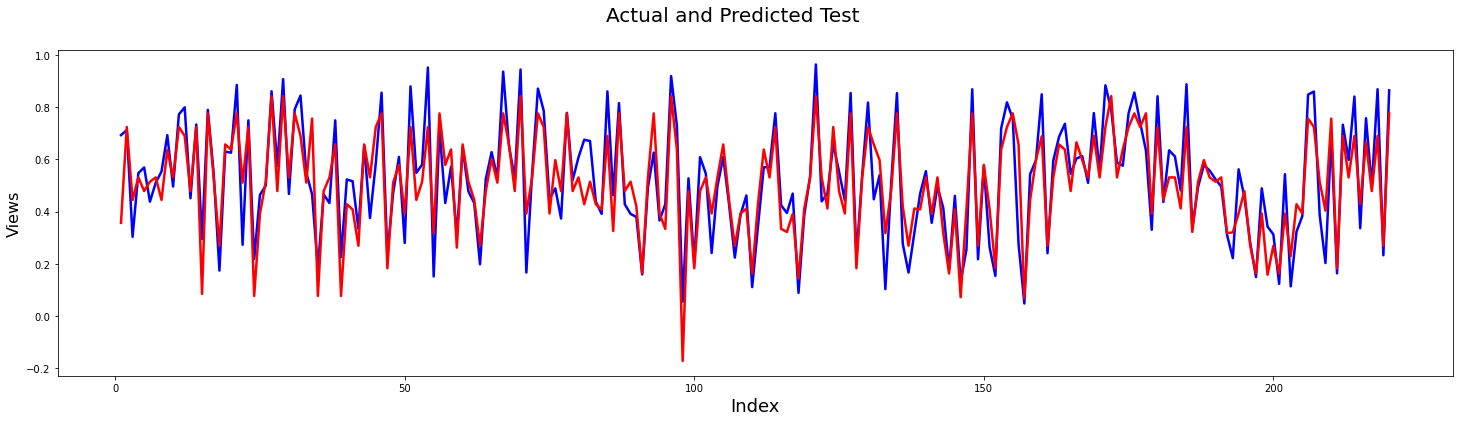

In [49]:
#Actual vs Predicted on test dataset
c = [i for i in range(1,221,1)]
fig = plt.figure(figsize=[25,6])
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_test_pred, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted Test', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)                               # Y-label

We can see that the equation of our best fitted line is:

$ cnt = 0.5309 + 0.2452  \times  yr 2019 - 0.0879  \times  holiday - 0.2616 \times Spring - 0.0521 \times Summer - 0.1109 \times Dec - 0.1062 \times Jan - 0.1189 \times Nov + 0.0662 \times Sep - 0.3349 \times Light Rain/Snow - 0.0861 \times Misty $

Overall we have a decent model, but I also acknowledge that we could do better. 

We can add temp/windspeed to the model 

The attained R-squared value in test dataset is 79.18 %
